# U-Net Image Segmentation in Keras

โค้ดนี้เป็นตัวอย่างการสร้าง U-net ใช้งานเอง
จริงๆแล้วอาจจะมี library ที่ออกมาสำเร็จรูปมากกว่านี้ ตัวอย่างนี้แสดงถึงรายละเอียดหลายๆอย่างของการสร้าง U-Net ซึ่งสามารถปรับเปลี่ยนอะไรได้หลายๆอย่างเลย
อาจจะปรับความลึก หรือ ปรับจำนวน Filter หวังว่าจะเป็นพื้นฐานที่จะช่วยให้นศ.เข้าใจการสร้าง Custom model ขึ้นมาเอง เพราะว่าในอณาคตการใช้ sequential นั้นอาจจะไม่เพียงพอต่อตัวงานของเรา

โค้ดนี้เป็นส่วนหนึ่งของวิชา Depp Learning for Computer Vision 517433 <br>
โดย อ.ดร.ภูริวัจน์ วรวิชัยพัฒน์

## Table of Contents

>[U-Net Image Segmentation in Keras](#scrollTo=LgNY4Ko8sw7q)

>>[Table of Contents](#scrollTo=cY6H4H4SdHJX)

>>[Setup](#scrollTo=53lnZ7YJe5Sw)

>>[Data](#scrollTo=pX631zhEouf4)

>>>[Load dataset from TFDS](#scrollTo=2AR5ZItbpc9R)

>>>[Data preprocessing](#scrollTo=QM9zPoS4phZl)

>>>[Data Visualization](#scrollTo=8zJZHJdc037v)

>>[U-Net Building blocks](#scrollTo=OjBm4atL-i4i)

>>[Build the U-Net Model](#scrollTo=dlcliXVXAk9v)

>>[Load pre-trained U-Net](#Load-pre-trained-U-net)

>>[Compile and Train U-Net](#scrollTo=PG-KtNSWWtWW)

>>[Learning curve from model history](#scrollTo=_bYfxa21Yj0f)

>>[Predictions with U-Net model](#scrollTo=RiG2W81uaS94)



## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

print(keras.__version__)
print(tf.__version__)

3.4.1
2.17.0


## Data

### Load dataset from TFDS
ในส่วนนี้เป็นการ load dataset มาจาก tensorflow ซึ่งเป็นข้อมูลเกี่ยวกับสัตว์เลี้ยง สามารถสั่งโหลดข้อมูลได้จากคำสั่งด้านล่างนี้
เป็นข้อมูลชุดใหญ่มากๆอาจจะต้องมีพื้นที่ว่างในคอมพิวเตอร์พอสมควร

เมื่อทำการเตรียมรูปภาพเป็นที่เรียบร้อยแล้วจะต้องผ่านกระบวนการต่างๆเพื่อให้รูปภาพนั้นไปใช้งานต่อได้ไม่ว่าจะเป็น
1. simple augmentation by flipping the image (ยังไม่ได้สอน เป็นกระบวนการที่ทำให้จำนวน training data นั้นเพิ่มขึ้น เพื่อให้โมเดลเทรนกับรูปที่เยอะขึ้น)
2. normalizing the pixel values
3. resizing the images

Masked label ของดาต้าเซ็ตนี้อยู่ในรูปแบบดังนี้

| Label            | Class Name     |
| -------------    | -------------  |
| 1                | foreground (pet)    |
| 2                | background     |
| 3                | Not Classified (outline) |


In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

เราสามารถพิมพ์ information ของชุดข้อมูลนี้ออกมาได้ด้วยโดยการพิมพ์พวกตัวแปร

`info` หรือ `dataset`

อยากให้สังเกตุว่าตัวแปร `dataset` นั้นสามารถเรียก "train" ออกมาได้เลย (สามารถใส่ "test" ได้ด้วย) ซึ่งจริงๆแล้ว dataset นี้นั้นทำการแบ่งออกมาให้เป็นชุดฝึกกับชุดทดสอบเป็นที่เรียบร้อยแล้ว

In [4]:
print(dataset)

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [5]:
print(dataset["train"])

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [6]:
print(dataset["test"])

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


### Data preprocessing
ด้านล่างนี้จะเป็นการประกาศ function ต่างๆที่กล่าวไว้ข้างบนเพื่อที่จะ process dataset ของเราให้พร้อมนำไป train U-Net นั่นเอง

In [7]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

In [8]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [9]:
def normalize(input_image, input_mask):
    # input_mask = tf.clip_by_value(input_mask,0,1)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int8)
    input_mask -= 2
    input_mask = tf.cast(tf.abs(input_mask),tf.uint8)

    return input_image, input_mask

เนื่องจากว่าตัว dataset ที่ได้มานั้นมี class label อยู่ตั้งสามคลาส แต่เพื่อให้เข้าใจได้ง่ายจะขอทำให้ class outline นั้นรวมเข้ากับ pet เลย
ให้ถือว่าเป็น segment เดียวกัน


นา label class ตอนแรกมาลบด้วย 2 จะได้

| Label            | Class Name     |
| -------------    | -------------  |
| -1                | pet    |
| 0                | background     |
| 1                | outline |

ใส่ abs() จะเห็นว่าคลาส pet กับ outline เป็นเลขเดียวกันแล้ว

| Label            | Class Name     |
| -------------    | -------------  |
| 1                | pet    |
| 0                | background     |
| 1                | outline |

ที่ทำแบบนี้เพื่อ้องการให้รูปแบบของ output นั้นมัน simple มากขึ้น masking class ในรูปแบบนี้จะเรียกว่า binary masking

In [10]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [11]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [12]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

*Note*:
ตัวแปร `tf.data.experimental.AUTOTUNE` ที่เห็นนี้คือค่าคงตัวที่บอกว่า อนุญาติให้เซ็ตพารามิเตอร์บางตัวแบบ Auto ไปเลย

ขั้นตอนถัดมานี้เป็นขั้นตอนที่สำคัญ เพราะเป็นตัวกำหนดว่าเราจะให้โมเดลของเรานั้นทำงานเป็นกี่ช่วง กำหนด batch ว่าเท่าไหร่

**ไม่ควรกำหนดไว้สูง เพราะ Ram การ์ดจอของเรานั้นอาจจะไม่พอที่จะเทรนก็เป็นได้**

สำหรับคนที่ใช้ Colab: แนะนำให้กำหนดไว้ 32 หรือ 64 ได้เลย <br>
สำหรับคนที่ใช้ การ์ดจอบนโน๊ตบุ้ค: ก็กำหนดไว้ที่ 16 ก็น่าจะเพียงพอ (ของอาจารย์สูงกว่านี้ไม่ได้แล้ว T T)

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

การจัดการ data แบบนี้เป็นการจัดการ data แบบใหม่ ที่อยู่ในรูปแบบของ tensorflow

In [14]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [15]:
print(train_batches) # print เพื่อดูรูปร่างของอาเรย์ของเราก็ได้

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


### Data Visualization

โค้ดด้านล่างนี้เป็นการยก data ที่เราเตรียมไว้ในตอนก่อนหน้ามาแสดงผล (เขียนไว้เผื่อตอนดูผล predicted ด้วยเช่นกัน)
ข้างในจะเป็นการ loop เพื่อใส่รูปเข้าไปใน subplot เป็นจำนวนเท่า len ของ `display_list`

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    # plt.colorbar()
    plt.axis("off")

  plt.show()

 `next()` ในที่นี้เป็นการดึง object ถัดไปจาก iteration (obj ที่เอาไป loop ได้) มาหนึ่งอัน

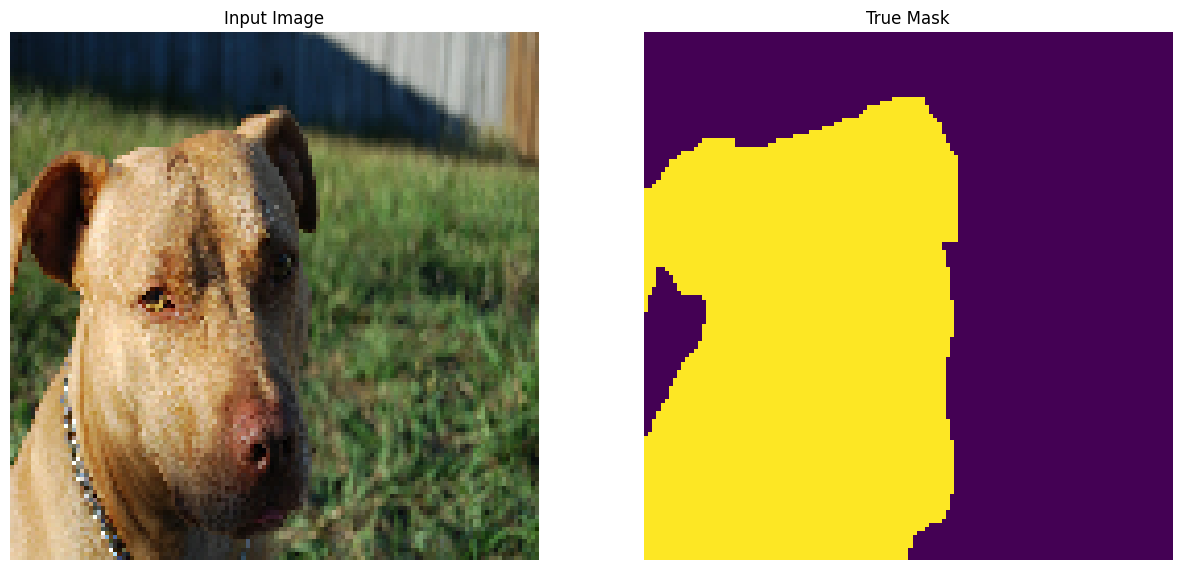

In [17]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]   # 0 คือภาพ, 1 คือ masked
display([sample_image, sample_mask])

In [18]:
sample_mask.shape


TensorShape([128, 128, 1])

## U-Net Building blocks

โค้ดในส่วนด้านล่างนี้เป็นการประการโครงสร้าง block ที่จำเป็นต่อการสร้าง U-Net (อธิบายไว้แล้วใน slide)

In [19]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [20]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [21]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

## Build the U-Net Model

หัวใจหลักของ U-net อยู่ที่ Function นี้เลย ที่เป็นการประกอบ block ต่างๆที่เราได้ประกาศไว้ด้านบนให้เป็นรูปเป็นร่าง
หรืออีกนัยหนึ่งคือมี flow, การทำงาน, และรูปทรงเดียวกับ U-Net นั่นเอง

ที่อยากให้เห็นโครงสร้างแบบนี้เพราะว่า ในอณาคตเราอาจจะต้องการโครงสร้าง Unet ที่ไม่ต้องมีหลายขั้นเท่านี้ หรือ มีชั้นมากกว่านี้ก็ได้ เพียงแค่ปรับเปลี่ยนโครงสร้างตรงนี้ หรือบางทีอาจจะปรับตัวแปรของ dropout หรือ ใส่ batchnormalisation เข้าไปก็เป็นได้

***ปรับขนาดของ Input image ก็ปรับตรงนี้เช่นกันหาต้องการไปใช้กับงานอื่นก็จำเป็นที่จะต้องปรับตรงนี้ให้เป็น***

ในที่นี้ input image ของเรามีขนาด 128x128x3 เพราะเมื่อกี้เราได้ทำการ print ดูแล้ว

In [22]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

แต่เอ๊ะเดียวก่อน แล้วทำไม `outputs` ถึงได้มีทั้งหมด 2 channel หละ???

เพราะว่า label ของ dataset นี้อย่างที่บอกว่ามีทั้งหมด 2 คลาสนั่นเอง เลยทำให้จำนวน channel เป็นเท่านี้

In [23]:
unet_model = build_unet_model()

In [24]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 512)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 34,513,410 (131.66 MB)

 Trainable params: 34,513,410 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

## Load pre-trained U-net

ผมได้ทำการเตรียมไฟล์ไว้ให้แล้วแต่เป็นการเทรนเพียงแค่ 5 epoch เท่านั้นไฟล์ที่ชื่อว่า "unet_model_CEloss_epoch5.h5"
เราสามารถโหลดโมเดลจากไฟล์นี้ได้เลย

อย่างไรก็ตามการที่จะโหลดโมเดลก็ต้องแน่ใจต้องว่าจะใช้กับงานประเภทไหนอย่างไร ในที่นี้ผมเทรนไว้ให้แล้วจึงสามารถใช้กับงานนี้ได้โดยตรง
หากใครไม่ต้องการเทรนและอยากทดลอง Predict ให้ข้ามไปรันที่ **[Prediction section](#Predictions-with-U-Net-model)** เลย

**อย่าลืมปลด comment `unet_model = pretrain`

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
%cd '/content/drive/MyDrive/week11/'
!dir

/content/drive/MyDrive/week11
unet_model_2class_20epoch.h5  unet_model_2class_5epoch.h5  unet_pet_segmentation.ipynb


In [27]:
pretrain = keras.models.load_model("unet_model_2class_5epoch.h5")

unet_model = pretrain

## Compile and Train U-Net

จะเห็นได้ว่า loss function ที่เราใช้ยังใช้ฟังก์ชั่นเดิมอยู่เลยก็คือ cross entropy ที่เป็นการเปรียบเทียบว่า assigm label หรือ class ถูกต้องหรือเปล่า
แต่ในงานของ Segmentation แล้ว class ที่ว่าคือ 1-pet, 2-background, และ 3-outline หมายความว่า จะเป็นการเทียบระดับ pixel เลยว่าแต่ละจุดนั้นใส่ class ตรงกับ groundtruth หรือไม่อย่างไร

ด้านล่างเป็นการนำ unet_model ที่เราได้ประกาศไว้แล้วมาเทรนกับดาต้าชุดนี้ สามารถปรับ epoch ได้ว่าอยากให้เทรนทั้งหมดกี่รอบ
อยากให้โมเดลเราเก่งขึ้นก็สามารถตั้งให้เป็น 10 หรือ 20 รอบก็ได้

หรือ อยากเอาโมเดล pretrain ที่โหลดมาเมื่อกี้มาเทรนซ้ำเข้าไปอีกรอบก็เพิ่มบรรทัดว่า

 `unet_nmodel = pretrain`

In [28]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [29]:
NUM_EPOCHS = 5

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 141s 629ms/step - accuracy: 0.8556 - loss: 0.3469 - val_accuracy: 0.8914 - val_loss: 0.2700
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 55s 478ms/step - accuracy: 0.8904 - loss: 0.2649 - val_accuracy: 0.9001 - val_loss: 0.2435
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 472ms/step - accuracy: 0.8969 - loss: 0.2507 - val_accuracy: 0.8966 - val_loss: 0.2504
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 469ms/step - accuracy: 0.9024 - loss: 0.2388 - val_accuracy: 0.9005 - val_loss: 0.2551
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 607ms/step - accuracy: 0.9074 - loss: 0.2280 - val_accuracy: 0.9177 - val_loss: 0.2140


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [30]:
# unet_model.save("unet_model_2class_5epoch.h5")

## Learning curve from model history

In [31]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

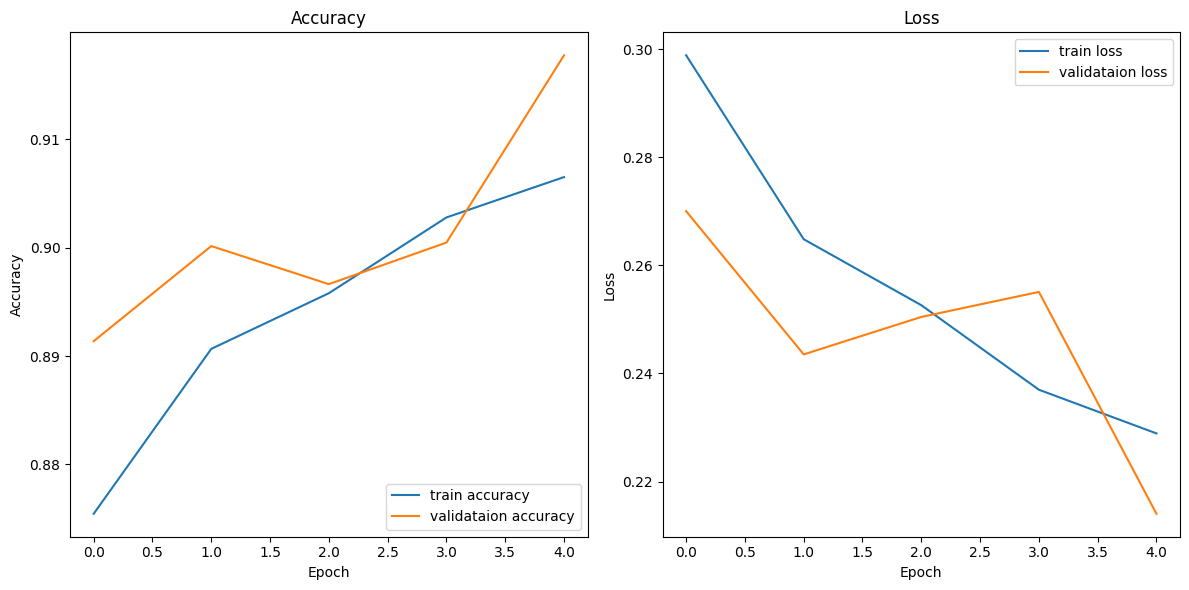

In [32]:
# Display learning curves
display_learning_curves(unet_model.history)

## Predictions with U-Net model

In [33]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [34]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [35]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 21


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


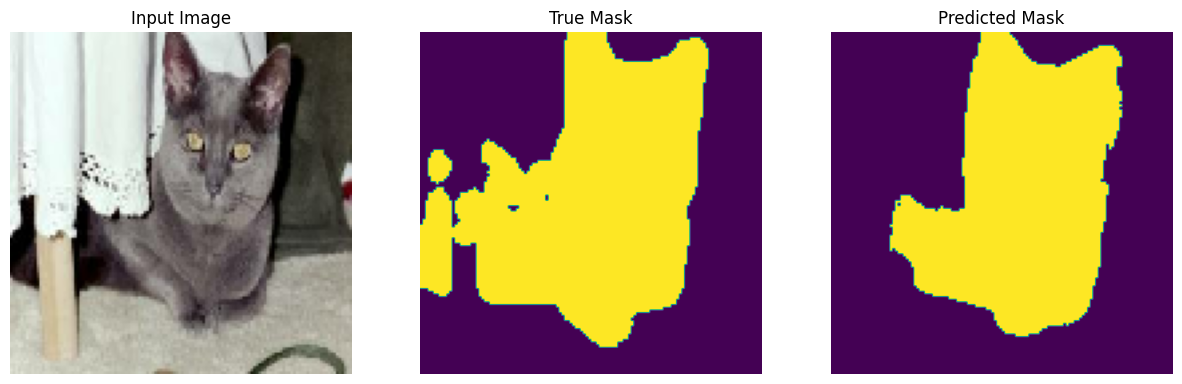

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


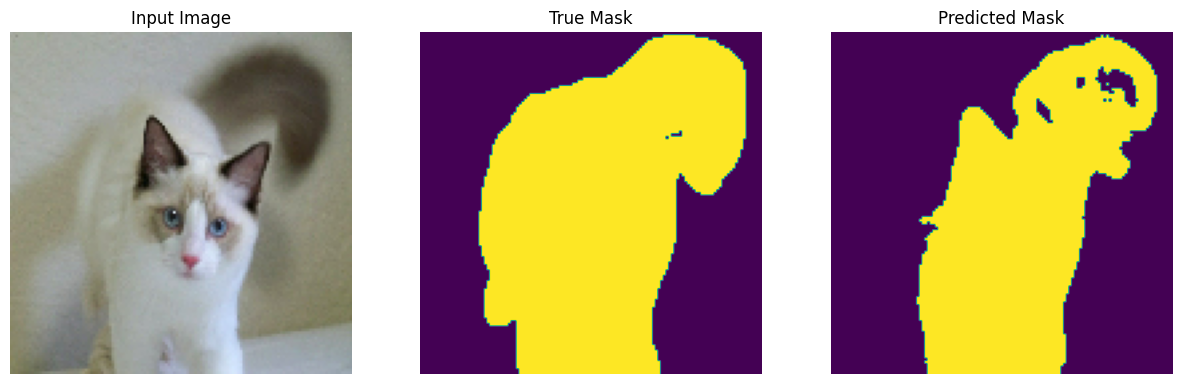

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


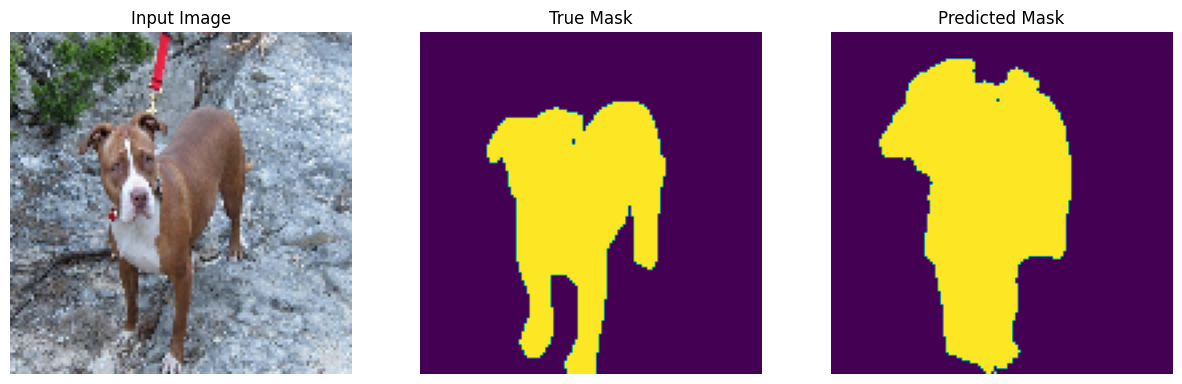

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


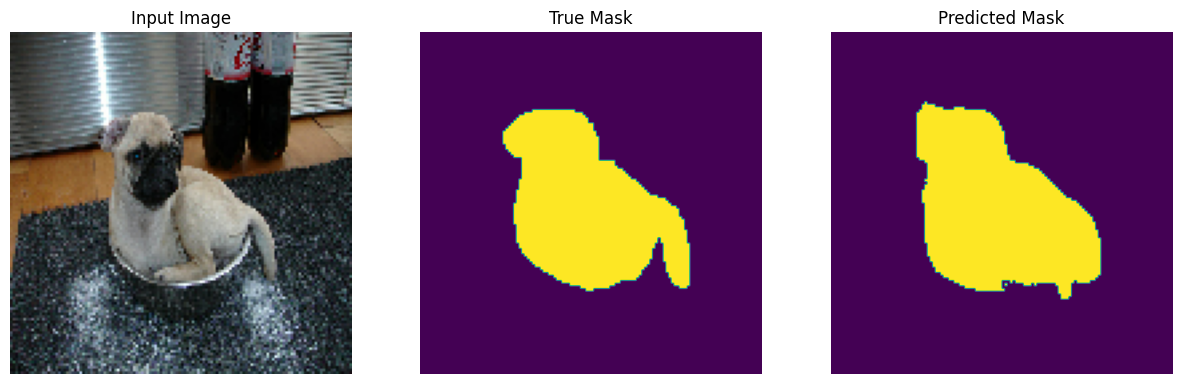

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


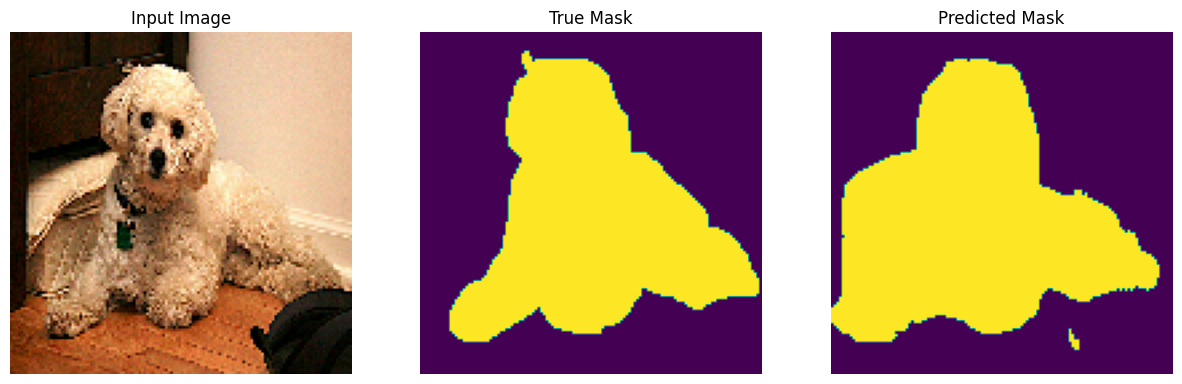

In [36]:
show_predictions(test_batches.skip(5), 5)